In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

/var/folders/nn/4_714bpd2qz7gm9d27_r3qw40000gn/T/ipykernel_57687/255157756.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
iris = sns.load_dataset('iris')

In [5]:
#organize the data

# Convert iris dataframe into torch tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()
labels = torch.zeros(len(data), dtype = torch.long)

# Transform species to number
labels[iris.species == 'versicolor'] = 1
labels[iris.species == 'virginica'] = 2

labels.shape

torch.Size([150])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size= 0.2, random_state= 42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batchSize = int(train_data.tensors[0].shape[0]/4)

train_loader = DataLoader(train_data, shuffle= True, batch_size = batchSize)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [9]:
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([30, 4]) torch.Size([30])
torch.Size([30, 4]) torch.Size([30])
torch.Size([30, 4]) torch.Size([30])
torch.Size([30, 4]) torch.Size([30])


In [10]:
for X, y in test_loader:
    print(X.shape, y.shape)

torch.Size([30, 4]) torch.Size([30])


In [26]:
# Create model

class ANNIris(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(4, 64)
        self.hidden = nn.Linear(64, 64)
        self.output = nn.Linear(64, 3)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden(x))
        x = self.output(x)
        
        return x

In [27]:
net = ANNIris()
random_data = torch.randn(50, 4)
yHat = net(random_data)
print(yHat)

tensor([[-8.0460e-02,  2.4070e-01, -6.8697e-01],
        [-2.8764e-02,  1.1200e-01, -3.0165e-01],
        [-1.6129e-01,  8.4246e-02, -3.0816e-01],
        [-1.3815e-01,  3.4163e-02, -2.1527e-01],
        [-1.1664e-01,  1.1362e-01, -3.0160e-01],
        [-9.4469e-02,  1.3831e-01, -3.0788e-01],
        [-2.3289e-01,  1.9782e-01, -3.6258e-01],
        [ 8.9683e-02, -4.3921e-02, -3.4355e-01],
        [-1.0075e-01,  1.5597e-01, -3.5760e-01],
        [-9.8820e-02,  9.4952e-03, -2.1011e-01],
        [ 9.8158e-02, -4.7602e-02, -2.0621e-01],
        [-1.3728e-01,  2.6049e-02, -1.9922e-01],
        [-2.3318e-01,  1.5800e-01, -3.6627e-01],
        [ 3.4753e-02, -6.4257e-02, -1.6500e-01],
        [-1.1405e-01,  7.2076e-02, -2.3880e-01],
        [-1.4650e-01,  1.1130e-01, -3.3390e-01],
        [ 2.5764e-04, -3.2620e-02, -2.2607e-01],
        [-9.6796e-02,  6.4767e-02, -2.5603e-01],
        [ 1.0431e-01, -5.9512e-02, -2.3781e-01],
        [-8.3852e-02, -5.7153e-02, -2.7153e-01],
        [ 8.2536e-02

In [29]:
def create_model(L2lambda):
    ANNIris_model = ANNIris()
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNIris_model.parameters(), lr= 0.005, weight_decay=L2lambda)
    
    return ANNIris_model, lossfun, optimizer

In [32]:
numepochs = 1000

def train_model(model, lossfun, optimizer):
    train_acc = []
    test_acc = []
    losses = []
    
    for epochi in range(numepochs):
        batch_acc = []
        batch_loss = []
        
        for X, y in train_loader:
            yHat = model(X)
            loss = lossfun(yHat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            predLabels = torch.argmax(yHat, axis = 1)
            acc = 100 * torch.mean((predLabels == y).float())
            batch_acc.append(acc)
            batch_loss.append(loss.item())
            
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        
        model.eval()
        X, y = next(iter(test_loader))
        yHat = model(X)
        predLabels = torch.argmax(yHat, axis = 1)
        acc = 100 * torch.mean((predLabels == y).float())
        
        test_acc.append(acc)
        model.train()
    
    return train_acc, test_acc, losses

In [33]:
L2lambda = .01
model, lossfun, optimizer = create_model(L2lambda)
train_acc, test_acc, losses = train_model(model, lossfun, optimizer)

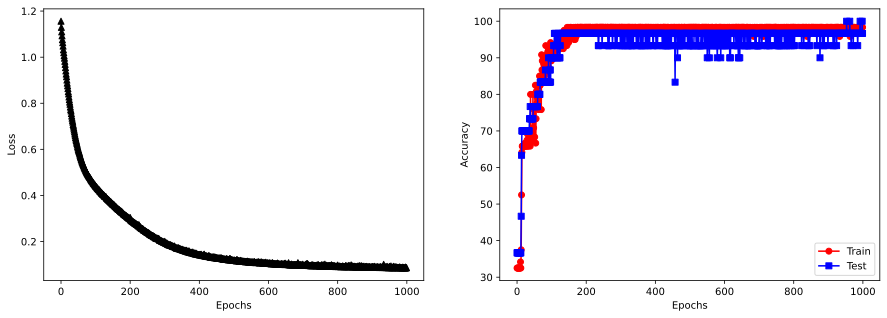

In [34]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(losses, 'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')

ax[1].plot(train_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend(['Train', 'Test'])

plt.show()


In [35]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [41]:
L2lambda = np.linspace(0, 0.1, 10)

trainAccResults = np.zeros((numepochs, len(L2lambda)))
testAccResults = np.zeros((numepochs, len(L2lambda)))

for li in range(len(L2lambda)):
    model, lossfun, optimizer = create_model(L2lambda[li])
    train_acc, test_acc, losses = train_model(model, lossfun, optimizer)
    
    trainAccResults[:, li] = smooth(train_acc, 10)
    testAccResults[:, li] = smooth(test_acc, 10)
    

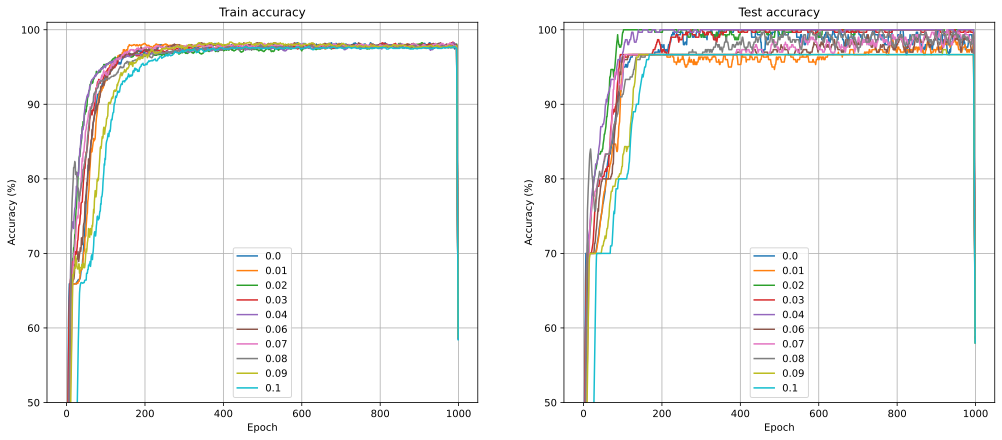

In [42]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(trainAccResults)
ax[0].set_title('Train accuracy')
ax[1].plot(testAccResults)
ax[1].set_title('Test accuracy')

# make the legend easier to read
leglabels = [np.round(i,2) for i in L2lambda]

# common features
for i in range(2):
  ax[i].legend(leglabels)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,101])
  ax[i].grid()

plt.show()

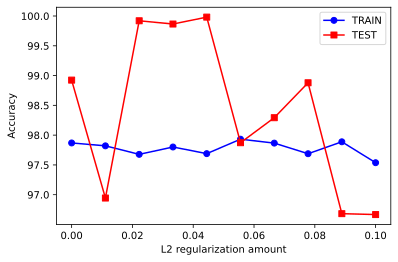

In [44]:
# show average accuracy by L2 rate

# average only some epochs
epoch_range = [500,950]


plt.plot(L2lambda,
         np.mean(trainAccResults[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='TRAIN')

plt.plot(L2lambda,
         np.mean(testAccResults[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='TEST')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()